<a href="https://colab.research.google.com/github/PiyushSawarkar/Node-Classification-Non-GNNs-to-SOTA-GNN/blob/main/OGBN_Arxiv_Exploration_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why GNNs Matter: A Survey of Node Classification Methods on ogbn-arxiv

## Setup

In [ ]:
# Install Required Packages
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install ogb

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 5.4 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 5.4 MB/s 
     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 407 kB 35.0 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=f22146203b8e3538c13e766ef8d08f2bd219038826933d05d1723691c1049d3b
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric
     |████████████████████████████████| 78 kB 3.3 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha

In [ ]:
# Import Packages
import torch
import torch.nn.functional as F
import torch_geometric
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

print(torch.__version__)
print(torch_geometric.__version__)

1.10.0+cu111
2.0.2


In [ ]:
# Reusable Logger Class (modified for only 1 run)
# https://github.com/snap-stanford/ogb/blob/master/examples/nodeproppred/arxiv/logger.py

class Logger(object):
    def __init__(self, info=None):
        self.info = info
        self.results = []

    def add_result(self, result):
        assert len(result) == 3
        self.results.append(result)

    def print_statistics(self):
        result = 100 * torch.tensor(self.results)
        argmax = result[:, 1].argmax().item()
        print(f'Highest Train: {result[:, 0].max():.2f}')
        print(f'Highest Valid: {result[:, 1].max():.2f}')
        print(f'  Final Train: {result[argmax, 0]:.2f}')
        print(f'   Final Test: {result[argmax, 2]:.2f}')

In [ ]:
# Helper function for visualization (from CS224W Colab 2)
# Modified to sample nodes (for tractability when plotting)
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize(h, color, sample=False):
    if sample:
      # Sample 1000 nodes to plot
      random_idx = np.random.choice(h.shape[0], size=1000)
      print(h.shape, color.shape)
      h = h[random_idx, :]
      color = color[random_idx]

    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Section 1: Non-GNN Methods
## MLP Model
We introduce a standard multi-layer perceptron model for the node classification task. This model does not take into account the neighborhood connectivity for classification; it only processes the individual node features.

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(MLP, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x):
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.log_softmax(x, dim=-1)


### Training, Testing, and Evaluation

In [ ]:
# Modify these hyperparameters to experiment with different architectures!
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 256,
    'epochs': 100,
    'lr': 0.01,
    'num_layers': 3,
    'dropout': 0.5,
    'log_steps': 2,
}

device = args['device']

In [ ]:
import torch_geometric.transforms as T

def train(model, x, y_true, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(x[train_idx])
    loss = F.nll_loss(out, y_true.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def test(model, x, y_true, split_idx, evaluator, out=None):
    model.eval()

    out = model(x) if out is None else out
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc, out

# Load Dataset
dataset = PygNodePropPredDataset(name='ogbn-arxiv', transform=T.ToSparseTensor(remove_edge_index=False))
split_idx = dataset.get_idx_split()
data = dataset[0]
data = data.to(device)
data.adj_t = data.adj_t.to_symmetric()

evaluator = Evaluator(name='ogbn-arxiv')

def runMLPExperiment(x, y_true, train_idx, visualize_emb=False):
  model = MLP(x.size(-1), args['hidden_size'], dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)

  logger = Logger(args)

  # Store best soft labels
  best_val_acc = 0.0
  y_soft = None

  model.reset_parameters()
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  for epoch in range(1, 1 + args['epochs']):
      loss = train(model, x, y_true, train_idx, optimizer)
      result = test(model, x, y_true, split_idx, evaluator)
      train_acc, valid_acc, test_acc, out = result
      logger.add_result((train_acc, valid_acc, test_acc))

      if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        y_soft = out.softmax(dim=-1)

      if epoch % args['log_steps'] == 0:
          print(f'Epoch: {epoch:02d}, '
                f'Loss: {loss:.4f}, '
                f'Train: {100 * train_acc:.2f}%, '
                f'Valid: {100 * valid_acc:.2f}%, '
                f'Test: {100 * test_acc:.2f}%')

  logger.print_statistics()
  if visualize_emb:
    out = model(x)
    out = out.detach().cpu().numpy()
    visualize(out, color=y_true.cpu(), sample=True)
  return model, y_soft


# Run experiment
train_idx = split_idx['train'].to(device)
model, y_soft = runMLPExperiment(data.x, data.y, train_idx)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:24<00:00,  3.30it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 7612.17it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1458.89it/s]

Saving...



Done!


Epoch: 02, Loss: 3.3290, Train: 17.91%, Valid: 7.63%, Test: 5.86%
Epoch: 04, Loss: 3.0974, Train: 18.01%, Valid: 7.86%, Test: 6.00%
Epoch: 06, Loss: 3.1170, Train: 20.10%, Valid: 12.15%, Test: 9.80%
Epoch: 08, Loss: 2.9797, Train: 25.02%, Valid: 23.30%, Test: 20.45%
Epoch: 10, Loss: 2.8870, Train: 26.82%, Valid: 28.87%, Test: 25.67%
Epoch: 12, Loss: 2.7590, Train: 27.48%, Valid: 28.42%, Test: 25.55%
Epoch: 14, Loss: 2.6572, Train: 28.61%, Valid: 30.87%, Test: 28.84%
Epoch: 16, Loss: 2.5895, Train: 31.11%, Valid: 32.38%, Test: 30.22%
Epoch: 18, Loss: 2.5164, Train: 33.35%, Valid: 34.28%, Test: 31.65%
Epoch: 20, Loss: 2.4472, Train: 34.97%, Valid: 37.92%, Test: 36.03%
Epoch: 22, Loss: 2.3989, Train: 36.85%, Valid: 39.73%, Test: 37.75%
Epoch: 24, Loss: 2.3446, Train: 37.82%, Valid: 39.91%, Test: 37.10%
Epoch: 26, Loss: 2.3001, Train: 39.14%, Valid: 41.98%, Test: 40.04%
Epoch: 28, Loss: 2.2665, Train: 40.18%, Valid: 43.07%, Test: 41.06%
Epoch: 30, Loss: 2.2302, Train: 41.26%, Valid: 43.76%

We obtain about 51% test accuracy by only considering node features in isolation! But can we do better?

## Node2Vec
Node2Vec is an algorithm that learns embedding representations for nodes in a graph that can be adapted for downstream machine learning tasks.

Crucially, it captures the node's local/global neighborhood structure, which can improve predictive power when used to augment ML models.

To demonstrate the power of Node2Vec, we will now augment the node features and apply it to the same MLP model shown above. Empirically, we observe much higher test accuracy, and this can be accomplished with very few lines of code.

In [ ]:
from torch_geometric.nn import Node2Vec

edge_idx_undir = torch_geometric.utils.to_undirected(data.edge_index, data.num_nodes)

# Change these hyperparameters and re-run to observe different results!
nodeToVec_args = {
    "embedding_dim": 128,
    "walk_length": 80,
    "context_size": 20,
    "walks_per_node": 10,
    "batch_size": 256,
    "lr": 0.01,
    "epochs": 5,
    "log_steps": 1,
}

# Train node2Vec Embeddings
nodeToVecModel = Node2Vec(edge_idx_undir, nodeToVec_args['walk_length'],
                                        nodeToVec_args['context_size'], nodeToVec_args['walks_per_node'], sparse=True).to(device)
loader = nodeToVecModel.loader(batch_size=nodeToVec_args['batch_size'], shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(nodeToVecModel.parameters()), lr=nodeToVec_args['lr'])

nodeToVecModel.train()
for epoch in range(1, nodeToVec_args['epochs'] + 1):
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = nodeToVecModel.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        if (i + 1) % nodeToVec_args['log_steps'] == 0:
            print(f'Epoch: {epoch:02d}, Step: {i+1:03d}/{len(loader)}, '
                  f'Loss: {loss:.4f}')

        if (i + 1) % 100 == 0:  # Save model every 100 steps.
            torch.save(nodeToVecModel.embedding.weight.data.cpu(), 'embedding.pt')
    torch.save(nodeToVecModel.embedding.weight.data.cpu(), 'embedding.pt')

del nodeToVecModel

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01, Step: 001/662, Loss: 7.5090
Epoch: 01, Step: 002/662, Loss: 7.5968
Epoch: 01, Step: 003/662, Loss: 7.5233
Epoch: 01, Step: 004/662, Loss: 7.5504
Epoch: 01, Step: 005/662, Loss: 7.6677
Epoch: 01, Step: 006/662, Loss: 7.5271
Epoch: 01, Step: 007/662, Loss: 7.6146
Epoch: 01, Step: 008/662, Loss: 7.5778
Epoch: 01, Step: 009/662, Loss: 7.5544
Epoch: 01, Step: 010/662, Loss: 7.5666
Epoch: 01, Step: 011/662, Loss: 7.5873
Epoch: 01, Step: 012/662, Loss: 7.5381
Epoch: 01, Step: 013/662, Loss: 7.5339
Epoch: 01, Step: 014/662, Loss: 7.5137
Epoch: 01, Step: 015/662, Loss: 7.4478
Epoch: 01, Step: 016/662, Loss: 7.5796
Epoch: 01, Step: 017/662, Loss: 7.5146
Epoch: 01, Step: 018/662, Loss: 7.6886
Epoch: 01, Step: 019/662, Loss: 7.5973
Epoch: 01, Step: 020/662, Loss: 7.5829
Epoch: 01, Step: 021/662, Loss: 7.5731
Epoch: 01, Step: 022/662, Loss: 7.6237
Epoch: 01, Step: 023/662, Loss: 7.4852
Epoch: 01, Step: 024/662, Loss: 7.5740
Epoch: 01, Step: 025/662, Loss: 7.3728
Epoch: 01, Step: 026/662,

torch.Size([169343, 80]) torch.Size([169343, 1])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


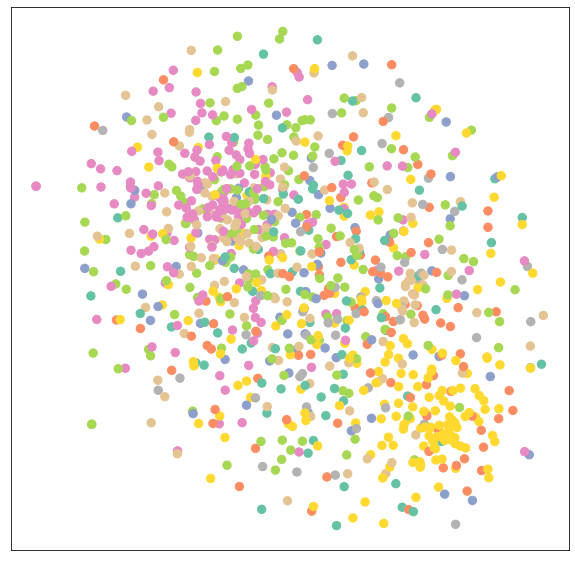

In [ ]:
embedding = torch.load('embedding.pt', map_location='cpu')
visualize(embedding, color=data.y.cpu(), sample=True)

Visualizing the Node2Vec embeddings of some sampled nodes from the graph, we see that the graph connectivity structure captures some information about the class of the nodes!

Now, we train the original MLP model, but this time concatenate the Node2Vec embeddings to the original node features

Epoch: 02, Loss: 3.2104, Train: 18.01%, Valid: 7.64%, Test: 5.87%
Epoch: 04, Loss: 2.9949, Train: 27.65%, Valid: 30.05%, Test: 26.82%
Epoch: 06, Loss: 3.0070, Train: 27.23%, Valid: 29.77%, Test: 26.65%
Epoch: 08, Loss: 2.8210, Train: 28.36%, Valid: 30.61%, Test: 27.95%
Epoch: 10, Loss: 2.7112, Train: 30.90%, Valid: 35.01%, Test: 33.57%
Epoch: 12, Loss: 2.6517, Train: 31.73%, Valid: 32.28%, Test: 29.04%
Epoch: 14, Loss: 2.5900, Train: 32.91%, Valid: 33.14%, Test: 29.87%
Epoch: 16, Loss: 2.5183, Train: 36.70%, Valid: 39.83%, Test: 38.82%
Epoch: 18, Loss: 2.4344, Train: 36.76%, Valid: 41.28%, Test: 40.70%
Epoch: 20, Loss: 2.3972, Train: 37.82%, Valid: 42.12%, Test: 41.85%
Epoch: 22, Loss: 2.3484, Train: 40.36%, Valid: 44.22%, Test: 43.69%
Epoch: 24, Loss: 2.2923, Train: 41.27%, Valid: 44.64%, Test: 43.64%
Epoch: 26, Loss: 2.2504, Train: 41.93%, Valid: 45.21%, Test: 44.32%
Epoch: 28, Loss: 2.1956, Train: 43.15%, Valid: 46.84%, Test: 46.64%
Epoch: 30, Loss: 2.1605, Train: 44.38%, Valid: 47.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


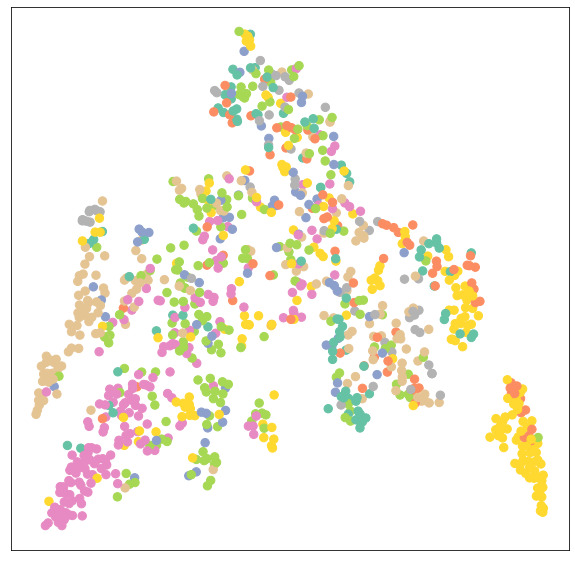

In [ ]:
# Concatenate Node2Vec Embedding
x_aug = torch.cat([data.x, embedding.to(device)], dim=-1)

model, y_soft = runMLPExperiment(x_aug, data.y, train_idx, visualize_emb=True)

From concatenating learned Node2Vec embeddings to the original node features and training a simple MLP classifier, we improve the test accuracy by more than 5%!

This begs the question -- what if we were to ONLY consider neighborhood connectivity, completely disregarding the node features? We introduce the next model to do just that.

## Label Propagation
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/label_prop.py

Even a traditional graph method like label propagation is highly performant on the node prediction task, achieving >65% accuracy on the test set!

Impressively, this method requires ZERO trainable parameters!

Note: this cell might take 1 minute or so to run

In [ ]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T
from torch_geometric.nn import LabelPropagation

model = LabelPropagation(num_layers=50, alpha=0.9)

out = model(data.y.cpu(), data.adj_t.cpu(), mask=split_idx['train'])

y_pred = out.argmax(dim=-1, keepdim=True)

val_acc = evaluator.eval({
    'y_true': data.y[split_idx['valid']],
    'y_pred': y_pred[split_idx['valid']],
})['acc']
test_acc = evaluator.eval({
    'y_true': data.y[split_idx['test']],
    'y_pred': y_pred[split_idx['test']],
})['acc']

print(f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Val: 0.6823, Test: 0.6551


## Correct and Smooth (C&S)
Now, we introduce the C&S technique, which post-processes soft labels generated by a base predictor (which, in this case, will be our MLP model trained with Node2Vec augmented features)

C&S is similar to label propagation.

In [ ]:
adj_t = data.adj_t
deg = adj_t.sum(dim=1).to(torch.float)
deg_inv_sqrt = deg.pow_(-0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
DAD = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
DA = deg_inv_sqrt.view(-1, 1) * deg_inv_sqrt.view(-1, 1) * adj_t

post = torch_geometric.nn.CorrectAndSmooth(num_correction_layers=50, correction_alpha=1.0,
                        num_smoothing_layers=50, smoothing_alpha=0.8,
                        autoscale=False, scale=20.)

y_soft = post.correct(y_soft, data.y[train_idx], train_idx, DAD)
y_soft = post.smooth(y_soft, data.y[train_idx], train_idx, DA)

train_acc, val_acc, test_acc, _ = test(model, data.x, data.y, split_idx, evaluator, y_soft)
print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Train: 0.8861, Val: 0.6819, Test: 0.6665


Our MLP + Node2Vec model's test accuracy improved **by almost 10%** from ~56% to ~66% by simply applying a C&S post-processing step. Neat!

So far, we've seen conceptually and empirically that the best predictors take into account both the node features and the graph's connectivity structure. How can we marry these concepts to produce state-of-the-art performance?

Introducing... GRAPH NEURAL NETWORKS!

#Section 2: GNN Models
We now introduce a core innovation -- Graph Neural Networks. In this section, we will see how training GNNs with Node2Vec feature augmentation and C&S post-processing can lead to superior results -- even better than using a base GNN predictor.

## GraphSAGE Model
https://github.com/snap-stanford/ogb/blob/master/examples/nodeproppred/arxiv/gnn.py

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return torch.log_softmax(x, dim=-1)


## GCN Model
https://github.com/snap-stanford/ogb/blob/master/examples/nodeproppred/arxiv/gnn.py

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)


## GAT Model
We adapt the above model architectures, simply replacing the GCNConv/SAGEConv layers with the GATConv layer, which is helpfully already implemented by PyG!

Note: sometimes this model runs out of CUDA memory when training on Colab.

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, heads=3):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GATConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GATConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)

In [ ]:
def train(model, data, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)[train_idx]
    loss = F.nll_loss(out, data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(model, data, split_idx, evaluator, out=None):
    model.eval()

    out = model(data.x, data.adj_t) if out is None else out
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc, out

In [ ]:
# Modify this variable to change the GNN model type to one of the above!
# options = {GCN, SAGE, GAT}
# Note: GAT will run out of Colab GPU memory on the basic version
GNN_TYPE = "SAGE"

# Set this flag to augment our GNN model with our trained
# Node2Vec embedding from section 1
augmentNodeToVec = False
if augmentNodeToVec:
  data.x = torch.cat([data.x, embedding.to(device)], dim=-1)

model = None
if GNN_TYPE == "SAGE":
  model = SAGE(data.num_features, args['hidden_size'],
                     dataset.num_classes, args['num_layers'],
                     args['dropout']).to(device)
elif GNN_TYPE == "GCN":
  model = GCN(data.num_features, args['hidden_size'],
                     dataset.num_classes, args['num_layers'],
                     args['dropout']).to(device)
elif GNN_TYPE == "GAT":
  model = GAT(data.num_features, args['hidden_size'],
                     dataset.num_classes, args['num_layers'],
                     args['dropout']).to(device)

logger = Logger(args)
evaluator = Evaluator(name='ogbn-arxiv')
data = data.to(device)

model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

# Store best soft labels
best_val_acc = 0.0
y_soft = None

losses = []
test_accs = []
for epoch in range(1, 1 + 500):
    loss = train(model, data, train_idx, optimizer)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc, out = result
    logger.add_result((train_acc, valid_acc, test_acc))

    losses.append(loss)
    test_accs.append(test_acc)

    if valid_acc > best_val_acc:
      best_val_acc = valid_acc
      y_soft = out.softmax(dim=-1)

    if epoch % args['log_steps'] == 0:
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

logger.print_statistics()

Epoch: 02, Loss: 3.6694, Train: 3.99%, Valid: 1.71% Test: 1.53%
Epoch: 04, Loss: 3.4937, Train: 5.12%, Valid: 10.19% Test: 10.01%
Epoch: 06, Loss: 3.3405, Train: 11.08%, Valid: 23.02% Test: 21.56%
Epoch: 08, Loss: 3.0708, Train: 32.47%, Valid: 35.46% Test: 34.07%
Epoch: 10, Loss: 2.8148, Train: 28.12%, Valid: 30.11% Test: 27.02%
Epoch: 12, Loss: 2.6064, Train: 31.21%, Valid: 31.61% Test: 28.36%
Epoch: 14, Loss: 2.4072, Train: 36.52%, Valid: 36.90% Test: 34.27%
Epoch: 16, Loss: 2.2584, Train: 41.52%, Valid: 44.77% Test: 43.48%
Epoch: 18, Loss: 2.1481, Train: 42.86%, Valid: 43.11% Test: 40.50%
Epoch: 20, Loss: 2.0617, Train: 45.10%, Valid: 48.37% Test: 47.06%
Epoch: 22, Loss: 1.9945, Train: 47.29%, Valid: 50.68% Test: 49.58%
Epoch: 24, Loss: 1.9429, Train: 48.22%, Valid: 51.36% Test: 50.32%
Epoch: 26, Loss: 1.8878, Train: 50.03%, Valid: 53.20% Test: 52.25%
Epoch: 28, Loss: 1.8501, Train: 51.14%, Valid: 55.16% Test: 54.85%
Epoch: 30, Loss: 1.8046, Train: 52.60%, Valid: 55.72% Test: 55.19%

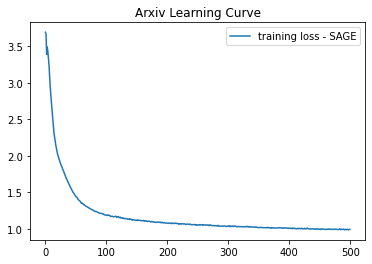

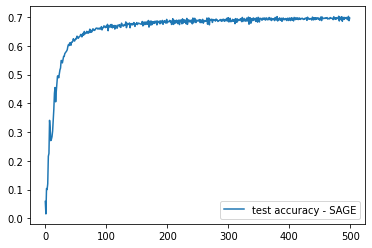

In [ ]:
# Plot learning curve
plt.title('Arxiv Learning Curve')
plt.plot(losses, label="training loss - " + GNN_TYPE)
plt.legend()
plt.show()
plt.plot(test_accs, label="test accuracy - " + GNN_TYPE)
plt.legend()
plt.show()

(169343, 40) torch.Size([169343, 1])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


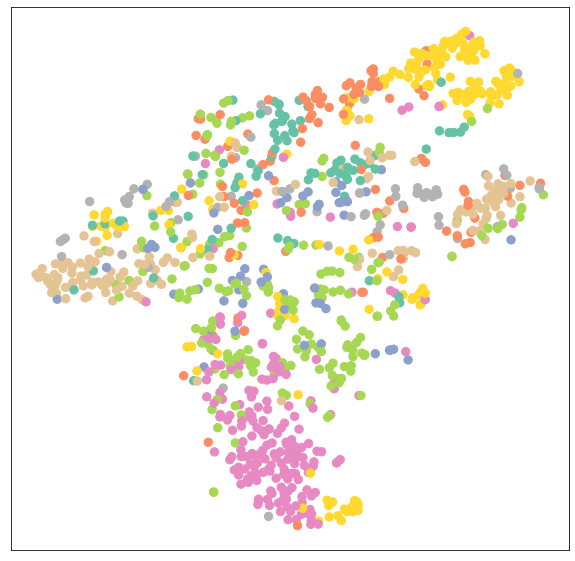

In [ ]:
torch.save(model.state_dict(), 'checkpoint_sage.pth')
with torch.no_grad():
  model.eval()
  out = model(data.x, data.adj_t)
  out = out.detach().cpu().numpy()
  visualize(out, color=data.y.cpu(), sample=True)

### Correct and Smooth
Now, we apply the same C&S technique that we used in the non-GNN section. This time, we use our state-of-the-art GraphSAGE GNN as our base predictor!

However, based on this paper: https://arxiv.org/abs/2010.13993 ("Combining Label Propagation and Simple Models Out-Performs Graph Neural Networks"), we ONLY apply the "Smooth" step -- the authors identify that for more complex baseline predictors like GNNs, the "Correct" step does not usually help performance.

In [ ]:
y_smooth = post.smooth(y_soft, data.y[train_idx], train_idx, DAD)

train_acc, val_acc, test_acc, _ = test(model, data, split_idx, evaluator, y_smooth)
print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Train: 0.9519, Val: 0.7238, Test: 0.7127


We see a modest gain (~1%) in test accuracy. Intuitively, since the GNN design already captures neighborhood connections through message passing, it makes sense that C&S doesn't give as dramatic of an improvement as it did when applied to post-process the MLP model.

## Quality > Quantity: The Over-Smoothing Problem
More layers/model complexity is not always good for model performance. If we add too many GNN layers, the receptive field (i.e., neighborhood taken into account by each node) effectively becomes the entire graph, and thus it is counter-intuitively MORE difficult to classify nodes.

To see this in practice, we will train a GNN with too many layers, and see how the accuracy drops dramatically.

In [ ]:
model = SAGE(data.num_features, args['hidden_size'],
                     dataset.num_classes, 10,
                     args['dropout']).to(device)

logger = Logger(args)

model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
for epoch in range(1, 1 + args['epochs']):
    loss = train(model, data, train_idx, optimizer)
    result = test(model, data, split_idx, evaluator)
    logger.add_result(result)

    if epoch % args['log_steps'] == 0:
        train_acc, valid_acc, test_acc = result
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

logger.print_statistics()

Epoch: 02, Loss: 7.4315, Train: 3.15%, Valid: 3.79% Test: 3.85%
Epoch: 04, Loss: 3.6177, Train: 4.92%, Valid: 3.99% Test: 3.46%
Epoch: 06, Loss: 3.5699, Train: 5.70%, Valid: 4.13% Test: 2.99%
Epoch: 08, Loss: 3.4814, Train: 7.72%, Valid: 12.27% Test: 10.88%
Epoch: 10, Loss: 3.3899, Train: 7.69%, Valid: 14.96% Test: 22.10%
Epoch: 12, Loss: 3.2866, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 14, Loss: 3.2086, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 16, Loss: 3.1578, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 18, Loss: 3.1284, Train: 17.77%, Valid: 8.19% Test: 6.23%
Epoch: 20, Loss: 3.1152, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 22, Loss: 3.1100, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 24, Loss: 3.1066, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 26, Loss: 3.1047, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 28, Loss: 3.1027, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 30, Loss: 3.0968, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 32, Loss: 3.0

## Addresing the over-smoothing problem: DeepGCNs
As analyzed in this paper: https://arxiv.org/abs/1904.03751, we find that we can use residual/dense connections (i.e., skip connections) to build deeper GCNs without succumbing to the oversmoothing problem. We will not cover the implementation in this notebook, as it is out of scope (and usually requires more computing resources to train than are available in Colab basic)

See https://github.com/pyg-team/pytorch_geometric/blob/master/examples/ogbn_proteins_deepgcn.py for an example

## GNN Scalability -- Neighborhood Sampling
Code adapted from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/ogbn_products_sage.py

### The Problem
As we've shown throughout this code exploration, GNNs are great at incorporating information from neighboring nodes/the implicit graph structure when making a classification decision for a target node.

We also showed how deeper GCN architectures can be built, solving the over-smoothing issue by adding residual connections

But -- how do we scale these methods to graphs with millions of nodes? How about billions of nodes?

The answer: neighborhood sampling!

### How does neighborhood sampling work?
In the message passing phase, instead of considering inputs from ALL neighboring nodes, we sample neighbors to take messages from, such that in expectations the results will be roughly the same, with much less computational cost!

In [ ]:
from tqdm import tqdm
from torch_geometric.loader import NeighborSampler

train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                               sizes=[15, 10, 5], batch_size=128,
                               shuffle=True, num_workers=1)
subgraph_loader = NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=512, shuffle=False,
                                  num_workers=1)


class SamplingSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all


model = SamplingSAGE(dataset.num_features, 256, dataset.num_classes, num_layers=3)
model = model.to(device)

y = data.y.squeeze()


def train(epoch):
    model.train()

    pbar = tqdm(total=train_idx.size(0))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out = model(data.x[n_id], adjs)
        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())
        pbar.update(batch_size)

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)

    return loss, approx_acc


@torch.no_grad()
def test():
    model.eval()

    out = model.inference(data.x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, val_acc, test_acc


model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

best_val_acc = final_test_acc = 0
for epoch in range(1, 21):
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')

    if epoch > 5:
        train_acc, val_acc, test_acc = test()
        print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
              f'Test: {test_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc

print('============================')
print(f'Final Test: {final_test_acc:.4f}')

Epoch 01: 100%|██████████| 90941/90941 [00:10<00:00, 8542.84it/s]


Epoch 01, Loss: 1.8222, Approx. Train: 0.4915


Epoch 02: 100%|██████████| 90941/90941 [00:10<00:00, 8334.22it/s]


Epoch 02, Loss: 1.5529, Approx. Train: 0.5570


Epoch 03: 100%|██████████| 90941/90941 [00:11<00:00, 8174.52it/s]


Epoch 03, Loss: 1.4958, Approx. Train: 0.5692


Epoch 04: 100%|██████████| 90941/90941 [00:10<00:00, 8521.13it/s]


Epoch 04, Loss: 1.4703, Approx. Train: 0.5776


Epoch 05: 100%|██████████| 90941/90941 [00:10<00:00, 8313.93it/s]


Epoch 05, Loss: 1.4440, Approx. Train: 0.5831


Epoch 06: 100%|██████████| 90941/90941 [00:11<00:00, 8245.96it/s]


Epoch 06, Loss: 1.4298, Approx. Train: 0.5871


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 66060.45it/s]


Train: 0.6302, Val: 0.6036, Test: 0.5427


Epoch 07: 100%|██████████| 90941/90941 [00:11<00:00, 7971.86it/s]


Epoch 07, Loss: 1.4170, Approx. Train: 0.5894


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 66390.25it/s]


Train: 0.6350, Val: 0.6012, Test: 0.5331


Epoch 08: 100%|██████████| 90941/90941 [00:11<00:00, 8004.52it/s]


Epoch 08, Loss: 1.4067, Approx. Train: 0.5928


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 65765.72it/s]


Train: 0.6349, Val: 0.6011, Test: 0.5364


Epoch 09: 100%|██████████| 90941/90941 [00:11<00:00, 8018.38it/s]


Epoch 09, Loss: 1.4002, Approx. Train: 0.5950


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 66973.89it/s]


Train: 0.6366, Val: 0.6006, Test: 0.5387


Epoch 10: 100%|██████████| 90941/90941 [00:10<00:00, 8360.02it/s]


Epoch 10, Loss: 1.3970, Approx. Train: 0.5966


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 67190.80it/s]


Train: 0.6351, Val: 0.6031, Test: 0.5402


Epoch 11: 100%|██████████| 90941/90941 [00:11<00:00, 8193.12it/s]


Epoch 11, Loss: 1.3915, Approx. Train: 0.5976


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 65957.90it/s]


Train: 0.6449, Val: 0.6023, Test: 0.5362


Epoch 12: 100%|██████████| 90941/90941 [00:11<00:00, 8012.20it/s]


Epoch 12, Loss: 1.3820, Approx. Train: 0.6005


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 65112.20it/s]


Train: 0.6442, Val: 0.6082, Test: 0.5448


Epoch 13: 100%|██████████| 90941/90941 [00:11<00:00, 7950.70it/s]


Epoch 13, Loss: 1.3816, Approx. Train: 0.6024


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 65549.85it/s]


Train: 0.6482, Val: 0.6074, Test: 0.5363


Epoch 14: 100%|██████████| 90941/90941 [00:11<00:00, 8024.39it/s]


Epoch 14, Loss: 1.3759, Approx. Train: 0.6000


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 65517.15it/s]


Train: 0.6470, Val: 0.6117, Test: 0.5535


Epoch 15: 100%|██████████| 90941/90941 [00:11<00:00, 7979.21it/s]


Epoch 15, Loss: 1.3723, Approx. Train: 0.6017


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 67928.95it/s]


Train: 0.6485, Val: 0.6096, Test: 0.5457


Epoch 16: 100%|██████████| 90941/90941 [00:10<00:00, 8277.31it/s]


Epoch 16, Loss: 1.3706, Approx. Train: 0.6025


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 66172.13it/s]


Train: 0.6474, Val: 0.6062, Test: 0.5396


Epoch 17: 100%|██████████| 90941/90941 [00:10<00:00, 8287.33it/s]


Epoch 17, Loss: 1.3619, Approx. Train: 0.6044


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 65808.51it/s]


Train: 0.6531, Val: 0.6065, Test: 0.5392


Epoch 18: 100%|██████████| 90941/90941 [00:11<00:00, 8229.52it/s]


Epoch 18, Loss: 1.3602, Approx. Train: 0.6077


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 64744.48it/s]


Train: 0.6524, Val: 0.6049, Test: 0.5373


Epoch 19: 100%|██████████| 90941/90941 [00:11<00:00, 8199.99it/s]


Epoch 19, Loss: 1.3568, Approx. Train: 0.6070


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 68225.10it/s]


Train: 0.6485, Val: 0.5971, Test: 0.5346


Epoch 20: 100%|██████████| 90941/90941 [00:11<00:00, 8064.56it/s]


Epoch 20, Loss: 1.3578, Approx. Train: 0.6069


Evaluating: 100%|██████████| 508029/508029 [00:07<00:00, 64846.74it/s]


Train: 0.6541, Val: 0.6025, Test: 0.5359
Final Test: 0.5535


We see that we can still achieve high performance, even without passing messages from ALL neighbors of a given node!

## Conclusion
With that, we conclude our Colab exploration. In this notebook, we explored a variety of approaches to the node classification problem. We started with non-GNN approaches that considered ONLY the neighborhood structure or the node features in isolation. Then, we realized we could achieve higher performance by combining the two with Node2Vec augmentation. From there, we saw how a simple post-processing step can supercharge our results. Finally, we walked through state-of-the-art GNN architectures, showing how they achieve the best performance on this task.

We hope you how have a better appreciation for the power and potential of machine learning on graphs, as well as the capabilities of the PyG library for making building/training these models effortless!